# Polynomial Regression

<div style="color:#F5B7B1; font-size:1.3em;">
    

<br>
    
What if your data is more complex than a straight line? Surprisingly, you can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called Polynomial Regression.

There are two factors when determining model performance: `overfitting` and `underfitting`. <br><span style="color:cyan;"><strong>Overfitting</strong></span> is when the model is too complex and does well on the training data but not on the test data. <br><span style="color:cyan;"><strong>Underfitting</strong></span> is when the model is too simple and performs poorly on the training and testing data sets.

Overfitting is simple to deal with, using methods like regularization, which we will discuss in the next lab. To deal with underfitting, we can build a more complex model using methods like polynomial regression. If making a more complex model does not work, this may involve using more data to train the model on or obtaining new features. As this process is complex, it's better to determine if the model can overfit the data first. Therefore, in this section, we will use Polynomial Regression to overfit the data to determine if we have an adequate amount of data.
    
</div>

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets import load_digits, load_wine

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, scale, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline


In [2]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

<div style="color:#F5B7B1; font-size:1.3em;">
    

<br>
    
The function below will calculate the $R^{2}$ on each feature given the a input model.

    
</div>

In [3]:
def get_R2_features(model,test=True): 
    #X: global  
    features=list(X)
    features.remove("three")
    
    R_2_train=[]
    R_2_test=[]

    for feature in features:
        model.fit(X_train[[feature]],y_train)
        
        R_2_test.append(model.score(X_test[[feature]],y_test))
        R_2_train.append(model.score(X_train[[feature]],y_train))
        
    plt.bar(features,R_2_train,label="Train")
    plt.bar(features,R_2_test,label="Test")
    plt.xticks(rotation=90)
    plt.ylabel("$R^2$")
    plt.legend()
    plt.show()
    print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
    print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )

<div style="color:#F5B7B1; font-size:1.3em;">
    

<br>
    
The function below will plot the distribution of two inputs.

    
</div>

In [4]:
def  plot_dis(y,yhat):
    
    plt.figure()
    ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

## Reading and understanding our data

<div style="color:#F5B7B1; font-size:1.3em;">
    

<br>
    
The car sales dataset contains all the information about cars, the name of the manufacturer, the year it was launched, all car technical parameters, and the sale price. This dataset has already been pre-cleaned and encoded (using one-hot and label encoders).
    
</div>

In [5]:
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/encoded_car_data.csv'

data = pd.read_csv(URL)
display(data.head())
print(data.info())

,diesel,gas,std,turbo,convertible,hardtop,hatchback,sedan,wagon,4wd,...,wheelbase,curbweight,enginesize,boreratio,horsepower,carlength,carwidth,citympg,highwaympg,price
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,13495.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,16500.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,94.5,2823.0,152.0,2.68,154.0,171.2,65.5,19.0,26.0,16500.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,99.8,2337.0,109.0,3.19,102.0,176.6,66.2,24.0,30.0,13950.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,99.4,2824.0,136.0,3.19,115.0,176.6,66.4,18.0,22.0,17450.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diesel       205 non-null    float64
 1   gas          205 non-null    float64
 2   std          205 non-null    float64
 3   turbo        205 non-null    float64
 4   convertible  205 non-null    float64
 5   hardtop      205 non-null    float64
 6   hatchback    205 non-null    float64
 7   sedan        205 non-null    float64
 8   wagon        205 non-null    float64
 9   4wd          205 non-null    float64
 10  fwd          205 non-null    float64
 11  rwd          205 non-null    float64
 12  dohc         205 non-null    float64
 13  dohcv        205 non-null    float64
 14  l            205 non-null    float64
 15  ohc          205 non-null    float64
 16  ohcf         205 non-null    float64
 17  ohcv         205 non-null    float64
 18  rotor        205 non-null    float64
 19  eight   

<div style="color:#F5B7B1; font-size:1.3em;">
    

<br>
    
We have 35 features in our dataset after the one hot encoding.

Before we begin our polynomial analysis, let's visualize some of the relationships between our features and the target variable `price`.
    
</div>

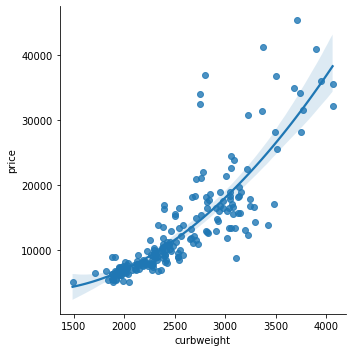

In [6]:
sns.lmplot(x = 'curbweight', y = 'price', data = data, order=2)

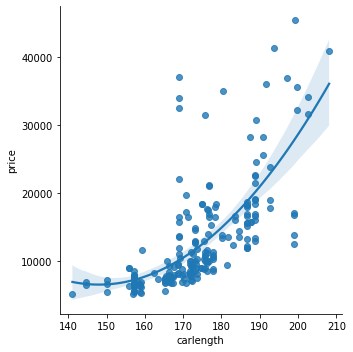

In [7]:
sns.lmplot(x = 'carlength', y = 'price', data = data, order=2)

### Task1

<div style="color:#F5B7B1; font-size:1.3em;">
    
    
Visualize the relationship between the `horsepower` and the target variable, `price`.
    
</div>

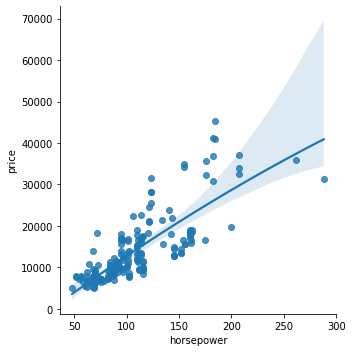

In [8]:
sns.lmplot(x = 'horsepower', y = 'price', data = data, order=2)

## Data Preparation

<div style="color:#F5B7B1; font-size:1.3em;">
    
    
Let's first split our data into `X` features and `y` target.
    
</div>

In [9]:
X = data.drop('price', axis=1)
y = data.price

<div style="color:#F5B7B1; font-size:1.3em;">
    
<br>    
Now, we split our data, using <code>train_test_split</code> function, into the training and testing sets, allocating 30% of the data for testing.
    
</div>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print("Number of test samples:", X_test.shape[0])
print("Number of training samples:", X_train.shape[0])

Number of test samples: 62
Number of training samples: 143


## Multiple Features

<div style="color:#F5B7B1; font-size:1.3em;">
    
    
Let's create a <code>LinearRegression</code> object, called `lm`.
    
</div>

In [11]:
lm = LinearRegression()
# do the fitting
lm.fit(X_train, y_train)
# apply the .predict() on testing data
predicted = lm.predict(X_test)
# calculate the r2_score() on both, training and testing data sets
print("R^2 on training  data ",lm.score(X_train, y_train))
print("R^2 on testing data ",lm.score(X_test,y_test))

R^2 on training  data  0.9261981895971949
R^2 on testing data  0.8500551011878996


<div style="color:#F5B7B1; font-size:1.3em;">
    
    
We can plot distributions of the predicted values versus the actual values.
    
</div>

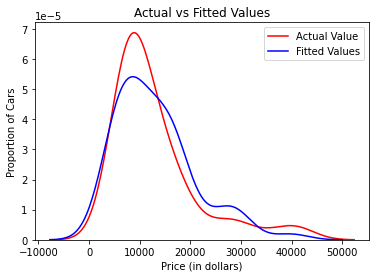

In [12]:
plot_dis(y_test,predicted)

<div style="color:#F5B7B1; font-size:1.3em;">
<br>    
Below, we will view the estimated coefficients for the linear regression problem.
    
</div>

In [13]:
{col:coef for col, coef in zip(X.columns, lm.coef_)}

{'diesel': -1348733091931160.2,
 'gas': -1348733091932830.8,
 'std': 328.09636017791996,
 'turbo': -379.0415743673835,
 'convertible': 1754.235437293915,
 'hardtop': 3038.425405937796,
 'hatchback': -1726.915116536612,
 'sedan': -655.3274707371338,
 'wagon': -2409.074307082546,
 '4wd': -632.1716184519332,
 'fwd': -321.51861763260297,
 'rwd': 954.3270108498389,
 'dohc': 2460.105523267882,
 'dohcv': -13356.354667660296,
 'l': 2135.3973376499416,
 'ohc': 4619.6241388433,
 'ohcf': 6075.189965805647,
 'ohcv': -2664.358428925572,
 'rotor': 729.6254714929158,
 'eight': 9205.568023694754,
 'five': -2679.9390212080825,
 'four': -5283.668295516305,
 'six': -2115.911567126084,
 'three': 0.0029296875,
 'twelve': 144.64806138435134,
 'two': 729.6342605554158,
 'wheelbase': 99.61247779746205,
 'curbweight': 4.789142482173508,
 'enginesize': 23.503149010125764,
 'boreratio': -1809.3275275247115,
 'horsepower': 68.62591613088244,
 'carlength': -63.72227335557646,
 'carwidth': 577.0394096646708,
 'city

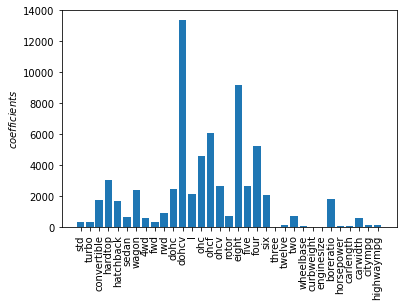

In [14]:
plt.bar(X.columns[2:],abs(lm.coef_[2:]))
plt.xticks(rotation=90)
plt.ylabel("$coefficients$")
plt.show()

### Individual Features

<div style="color:#F5B7B1; font-size:1.3em;">
   
We can train the model and plot our $R^2$ for each of the features on the training and testing data sets, using the function <code>get_R2\_features</code>.
    
</div>

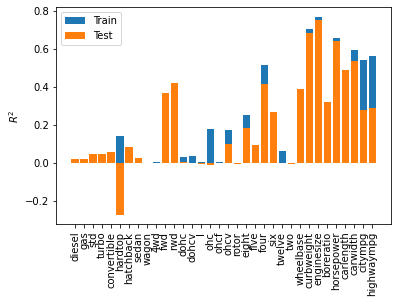

Training R^2 mean value 0.21817773426877915 Testing R^2 mean value 0.18241493035139267 
Training R^2 max value 0.7686929078033781 Testing R^2 max value 0.7534902447506853 


In [15]:
get_R2_features(lm)

<div style="color:#F5B7B1; font-size:1.3em;">
   
>From the above plot, we see that some individual features perform similarly to  using all the features (we removed the feature `three` ), in  addition, we see that smaller coefficients seem to correspond to a larger $R^{2}$, therefore  larger coefficients correspond to overfiting.

    
</div>

### Task2

<div style="color:#F5B7B1; font-size:1.3em;">
    
    
In this Exercise, calculate the $R^2$ using the object Pipeline for  Linear Regression and apply `StandardScaler()` to all features, then use the function `plot_dis` to compare the predicted values versus the actual values.
    
</div>

R^2 on training  data  0.9262722224294516
R^2 on testing data  0.8419174509630335


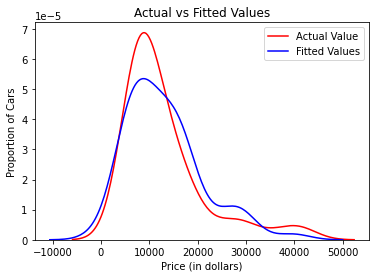

In [16]:
pipe = Pipeline([('ss', StandardScaler()),('lr', LinearRegression())])
pipe.fit(X_train,y_train)
print("R^2 on training  data ", pipe.score(X_train, y_train))
print("R^2 on testing data ", pipe.score(X_test,y_test))
predicted = pipe.predict(X_test)
plot_dis(y_test,predicted)

### Task3

<div style="color:#F5B7B1; font-size:1.3em;">
    
    
In this Exercise, calculate the $R^2$ using the object Pipeline with  `StandardScaler()` for each individual features using the function `get_R2_features`.
    
</div>

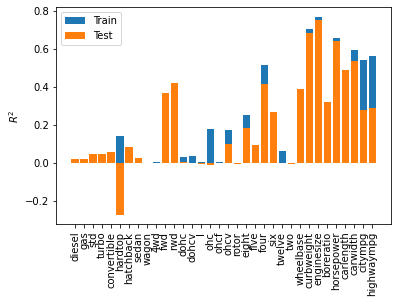

Training R^2 mean value 0.21817773426877915 Testing R^2 mean value 0.18241493035139267 
Training R^2 max value 0.7686929078033782 Testing R^2 max value 0.7534902447506853 


In [17]:
pipe = Pipeline([('ss',StandardScaler() ),('lr', LinearRegression())])
get_R2_features(pipe)

## Polynomial Features

### Multiple Features

<div style="color:#F5B7B1; font-size:1.3em;">
    
    
Polynomial transform is a simple way to increase the complexity of the model, but we must be mindful of overfilling. Below, we will perform a second degree (degree=2) polynomial transformation.
    
</div>

In [18]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [19]:
# transform the training and testing data sets
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

<div style="color:#F5B7B1; font-size:1.3em;">
<br>
    
`X_train_poly` and `X_test_poly` now contain the original features of X plus the square of these features and the cross-terms combination.
Let's check the shape of the newly created train and test sets.
    
</div>

In [20]:
print("X_train_poly shape: ", X_train_poly.shape)
print("X_test_poly shape: ", X_test_poly.shape)

X_train_poly shape:  (143, 665)
X_test_poly shape:  (62, 665)


<div style="color:#F5B7B1; font-size:1.3em;">
    
Altogether, we have 665 features. Now, we fit the model with the newly created features.

    
</div>

In [21]:
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

LinearRegression()

In [22]:
predicted = lm.predict(X_train_poly)

<div style="color:#F5B7B1; font-size:1.3em;">
<br>
    
Again, we can ckeck the `r2_score()` on both, training and testing data sets.

    
</div>

In [23]:
print("R^2 on training data:", lm.score(X_train_poly, y_train))
print("R^2 on testing data:", lm.score(X_test_poly,y_test))

R^2 on training data: 0.9985318497975861
R^2 on testing data: -36729.957800758064


<div style="color:#F5B7B1; font-size:1.3em;">
    
→ We see the model has a negative $R^{2}$ on the test data set, this is sign of <strong>overfiting</strong>.
    
</div>

## Individual Features

<div style="color:#F5B7B1; font-size:1.3em;">
    
<p>Data Pipelines simplify the steps of processing the data. We use the module <code>Pipeline</code> to create a pipeline. We also use <code>PolynomialFeatures</code> as a step in our pipeline.</p>

    
</div>

In [24]:
Input = [('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model', LinearRegression())]

<div style="color:#F5B7B1; font-size:1.3em;">
<br>
    
We can repeat the steps above, using the <code>Pipleine</code> object.
    
</div>

In [25]:
pipe=Pipeline(Input)
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [26]:
print("R^2 on training  data:", pipe.score(X_train, y_train))
print("R^2 on testing data:", pipe.score(X_test,y_test))

R^2 on training  data: 0.9985318497975861
R^2 on testing data: -36729.957800758064


<div style="color:#F5B7B1; font-size:1.3em;">
    
→ We can see the results are identical.
    
</div>

<div style="color:#F5B7B1; font-size:1.3em;">
<br>
    
We can train our model on each of the features using the Polynomial Feature transform of the second degree. Then we can plot our $R^2$.
    
</div>

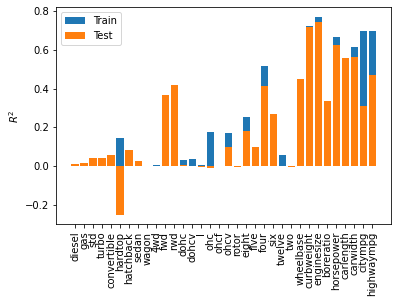

Training R^2 mean value 0.2306865256222299 Testing R^2 mean value 0.194039329276013 
Training R^2 max value 0.7706959974452947 Testing R^2 max value 0.7463370080614307 


In [27]:
get_R2_features(pipe)

<div style="color:#F5B7B1; font-size:1.3em;">
    
→ Feature with the max $R^{2}$ is higher than when using all the features.

    
</div>

## GridSearch and  Pipeline

<div style="color:#F5B7B1; font-size:1.3em;">
    
In this section of the notebook, we will define a pipeline object, then use GridSearch to find the best hyper-parameters of the model by using cross-validation method of the parameter grid, as shown in the figure below. A 5-fold cross validation is used by default. We will learn more about k-fold cross validation in the next, Cross Validation lesson of the Course.

    
<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/images/k-fold.png"  />
</center>
    
</div>

In [28]:
# create `PolynomialFeatures()` pipeline
Input = [('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model',LinearRegression())]
pipe = Pipeline(Input)

<div style="color:#F5B7B1; font-size:1.3em;">
    
To search for the best combination of hyperparameters, we create a  <b>GridSearchCV</b> object with dictionary of parameter values. The parameters of pipelines can be set using the name of the key separated by
'\__', then the parameter name of the key.
    
</div>

In [29]:
param_grid = {
    "polynomial__degree": [1, 2, 3],
    "model__normalize":[True, False]
}

<div style="color:#F5B7B1; font-size:1.3em;">
    
<b>polynomial\_\_degree</b> is the degree of the polynomial.<br>
<b>model\_\_normalize</b> This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm.
    
</div>

<div style="color:#F5B7B1; font-size:1.3em;">
    
The model is overfitting.

    
</div>

In [30]:
search = GridSearchCV(pipe, param_grid, n_jobs=1)

In [31]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [33]:
search.fit(X_test, y_test)

GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(include_bias=False)),
                                       ('model', LinearRegression())]),
             n_jobs=1,
             param_grid={'model__normalize': [True, False],
                         'polynomial__degree': [1, 2, 3]})

<div style="color:#F5B7B1; font-size:1.3em;">
    <br>
The object finds the best parameter values on the validation data. We can obtain the estimator with the best parameters and assign it to the variable `best`, as follows:
    
</div>

In [34]:
best=search.best_estimator_
best

Pipeline(steps=[('polynomial',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('model', LinearRegression(normalize=True))])

In [35]:
# test the model on the test data to see the best score
best.score(X_test,y_test)

0.967749925655019

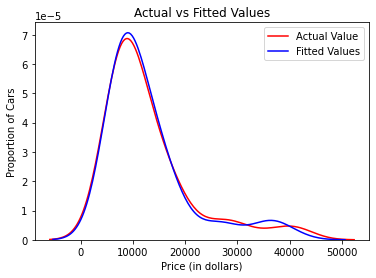

In [36]:
# plot a distribution of the predicted values versus the actual values
predicted=best.predict(X_test)
plot_dis(y_test,predicted)

<div style="color:#F5B7B1; font-size:1.3em;">

→ As we see, the result is almost perfect! <span style="color:green; font-size:1.5em;">&#10003;</span>
    
</div>

### Task4

<div style="color:#F5B7B1; font-size:1.3em;">
    
In this Exercise, calculate the $R^2$ using the object `Pipeline` with `GridSearch` for each individual features.

    
</div>

diesel | gas | std | turbo | convertible | hardtop | hatchback | sedan | wagon | 4wd | fwd | rwd | dohc | dohcv | l | ohc | ohcf | ohcv | rotor | eight | five | four | six | three | twelve | two | wheelbase | curbweight | enginesize | boreratio | horsepower | carlength | carwidth | citympg | highwaympg | 

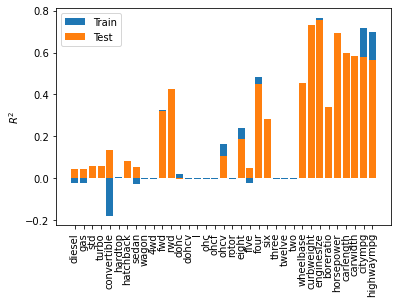

Training R^2 mean value 0.18469498230987366 Testing R^2 mean value 0.2171561572559849 
Training R^2 max value 0.765323637379124 Testing R^2 max value 0.7565151400968062 


In [37]:
features=list(X)


R_2_train=[]
R_2_test=[]

for feature in features:
    param_grid = {
    "polynomial__degree": [1,2,3,4,5],
    "model__positive":[True, False]}
    
    Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model',LinearRegression())]
    pipe=Pipeline(Input)
    print(feature, end=' | ')
    search = GridSearchCV(pipe, param_grid, n_jobs=2)
    search.fit(X_test[[feature]], y_test)
    best=search.best_estimator_

    R_2_test.append(best.score(X_test[[feature]],y_test))
    R_2_train.append(best.score(X_train[[feature]],y_train))


plt.bar(features,R_2_train,label="Train")
plt.bar(features,R_2_test,label="Test")
plt.xticks(rotation=90)
plt.ylabel("$R^2$")
plt.legend()
plt.show()
print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )